# Twitter Disaster Classifier
Disaster Response and Emergency Management Using Social Media Data

**Project Type: Natural Language Processing**

The goal of this project is to leverage machine learning models to analyze social media data, specifically tweets, to identify and manage disaster-related incidents in real-time. By accurately classifying tweets as related to disasters or not, emergency management teams can improve response times, allocate resources more effectively, and enhance overall disaster response strategies.


# Import necessary libraries

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Load the Disaster Tweets
Tweets collected from Twitter using hashtags and keywords related to various disasters (e.g., floods, earthquakes, fires).


In [2]:
# Load the datasets
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

print('Training Set Shape = {}'.format(df_train.shape))
print('Test Set Shape = {}'.format(df_test.shape))

Training Set Shape = (7613, 5)
Test Set Shape = (3263, 4)


In [3]:
# Display the first few rows of each dataset to understand their structure
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


**Training Data (train.csv):**

- id: Unique identifier for each tweet.

- keyword: Keyword from the tweet.

- location: Location where the tweet was sent from.

- text: The tweet's content.

- target: Target label (1 if the tweet is about a real disaster, 0 if not).

In [4]:
# Display the first few rows of each dataset to understand their structure
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


**Test Data (test.csv):**

- id: Unique identifier for each tweet.

- keyword: Keyword from the tweet.

- location: Location where the tweet was sent from.

- text: The tweet's content.

# Explore the dataset


In [5]:
df_train.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

The missing values in the keyword and location columns will not impact the model training, as the model relies only on the text and target columns.

In [6]:
df_train["length"] = df_train["text"].apply(lambda x : len(x))
df_test["length"] = df_test["text"].apply(lambda x : len(x))

print("Train Length Stat")
print(df_train["length"].describe())
print()

print("Test Length Stat")
print(df_test["length"].describe())

Train Length Stat
count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: length, dtype: float64

Test Length Stat
count    3263.000000
mean      102.108183
std        33.972158
min         5.000000
25%        78.000000
50%       109.000000
75%       134.000000
max       151.000000
Name: length, dtype: float64


#### Insight from Text Length Statistics

The statistics for the text length in both the training and testing datasets provide valuable insights into the distribution of tweet lengths:

**Training Set Length Statistics:**

- Count: 7613 tweets
- Mean: 101 characters
- Standard Deviation: 33.78 characters
- Min Length: 7 characters
- 25th Percentile: 78 characters
- Median (50th Percentile): 107 characters
- 75th Percentile: 133 characters
- Max Length: 157 characters

**Testing Set Length Statistics:**

- Count: 3263 tweets
- Mean: 102 characters
- Standard Deviation: 33.97 characters
- Min Length: 5 characters
- 25th Percentile: 78 characters
- Median (50th Percentile): 109 characters
- 75th Percentile: 134 characters
- Max Length: 151 characters

**Summary:**
- The average tweet length is approximately 101-102 characters in both datasets.
- The distribution of tweet lengths is similar between the training and testing sets, with standard deviations around 34 characters.
- The median tweet length is slightly over 100 characters.
- The maximum tweet lengths are 157 and 151 characters for the training and testing sets, respectively.

These insights indicate that the length of tweets is fairly consistent between the training and testing datasets, which is beneficial for model training and evaluation.

In [7]:
# Check for missing values in the location column
df_train['location'].fillna('Unknown', inplace=True)

Purpose: The replacement of missing values with 'Unknown' is aimed at maintaining data integrity and ensuring consistency in the location column.


#### Plot the relationship between location and target


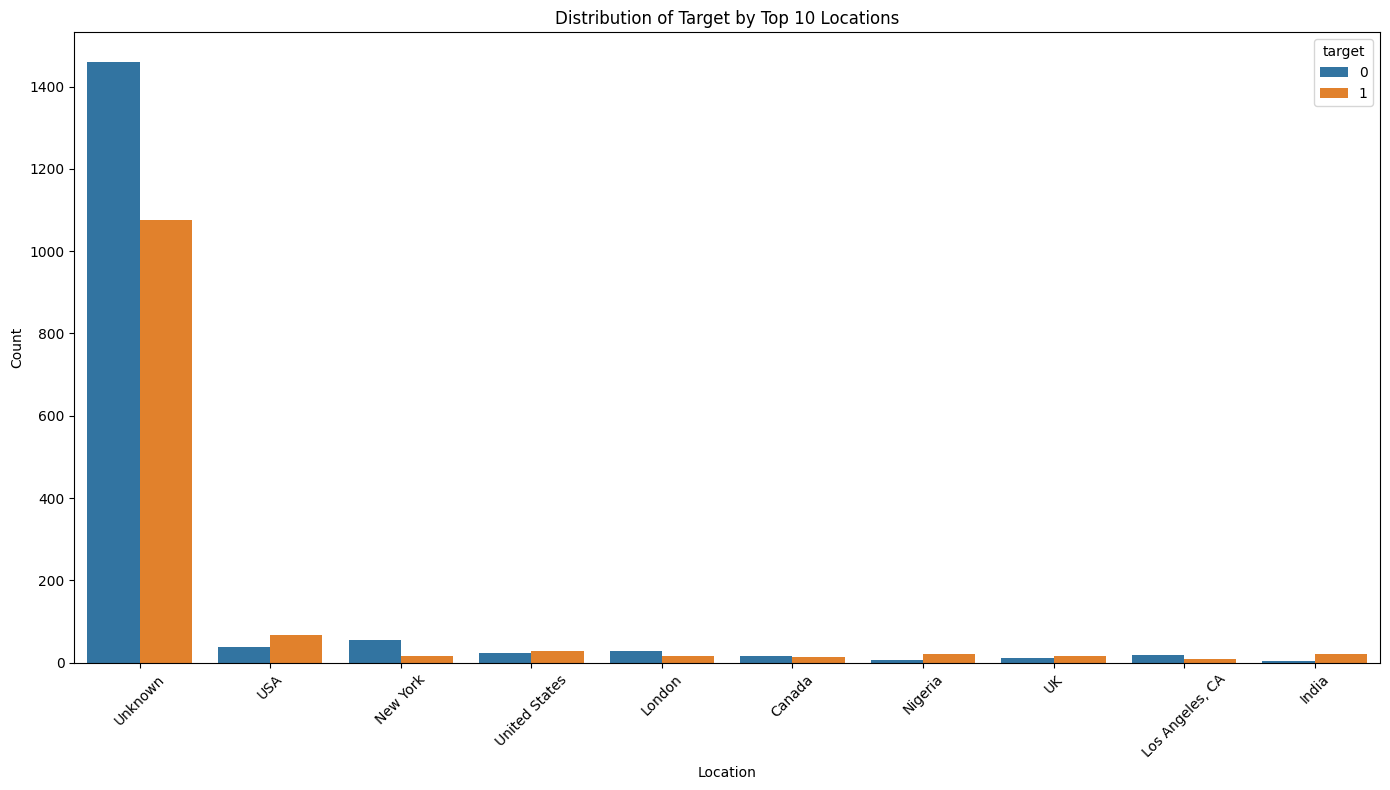

In [8]:
# Focus on the top 10 locations by count
top_locations = df_train['location'].value_counts().nlargest(10).index
filtered_data = df_train[df_train['location'].isin(top_locations)]

# Plot the relationship for the top 10 locations
plt.figure(figsize=(14, 8))

# Create a count plot for the top locations
sns.countplot(data=filtered_data, x='location', hue='target', order=top_locations)

# Customize the plot
plt.title('Distribution of Target by Top 10 Locations')
plt.xlabel('Location')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Show the plot
plt.tight_layout()
plt.show()

# Data Preprocessing

**1- Clean the tweet text (remove special characters, URLs, and HTML tags).**

**2- Normalize the text (convert to lowercase, removing stopwords, and applying stemming or lemmatization).**

**3- Tokenize the text to convert sentences into individual words or tokens for further analysis.**


In [9]:
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk

# Initialize lemmatizer and stop words list
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Function to clean tweet text
def preprocess_text(text):
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Tokenize text
    tokens = nltk.word_tokenize(text)
    # Remove stop words and lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    text = ' '.join(tokens)
    return text

# Apply preprocessing to the training and test datasets
df_train['cleaned_text'] = df_train['text'].apply(preprocess_text)
df_test['cleaned_text'] = df_test['text'].apply(preprocess_text)

# Display the first few rows of the preprocessed training data
df_train[['text', 'cleaned_text']].head()

,text,cleaned_text
0,Our Deeds are the Reason of this #earthquake M...,deed reason earthquake may allah forgive u
1,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are ...,resident asked shelter place notified officer ...
3,"13,000 people receive #wildfires evacuation or...",people receive wildfire evacuation order calif...
4,Just got sent this photo from Ruby #Alaska as ...,got sent photo ruby alaska smoke wildfire pour...


**The tweets have been successfully cleaned and preprocessed. The cleaned_text column now contains the processed text.**

# Feature Extraction


**1- Convert text data into numerical format using techniques like TF-IDF or word embeddings.**

**2- Consider additional features (e.g., tweet length, specific keywords).**.

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Feature extraction: TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

X_train = tfidf_vectorizer.fit_transform(df_train['cleaned_text']).toarray()
y_train = df_train['target'].values

X_test = tfidf_vectorizer.transform(df_test['cleaned_text']).toarray()

# Model Training and Selection and Model Evaluation

**1- Divide the dataset into training and testing sets for model evaluation.**

**2- Train different machine learning models (e.g., Naive Bayes, Logistic Regression, Support Vector Machines, neural networks).**

**3- Use cross-validation to optimize model parameters and prevent overfitting.**

**4- Use metrics (e.g., accuracy, precision, recall, F1-score) to evaluate the model's performance.**
**5-  Review the confusion matrix for each model to identify classification errors**.

In [11]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [12]:
# Split the training data for validation
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Model Training and Selection
def train_and_evaluate_model(model, X_train, y_train, X_val, y_val):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    cm = confusion_matrix(y_val, y_pred)
    return accuracy, precision, recall, f1, cm

In [13]:
# Initialize models
models = {
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Support Vector Machine": SVC(kernel='linear')
}

In [14]:
# Evaluate models
results = {}
for model_name, model in models.items():
    accuracy, precision, recall, f1, cm = train_and_evaluate_model(model, X_train_split, y_train_split, X_val, y_val)
    results[model_name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "Confusion Matrix": cm
    }

In [15]:
# Print results
for model_name, metrics in results.items():
    print(f"Model: {model_name}")
    print(f"Accuracy: {metrics['Accuracy']}")
    print(f"Precision: {metrics['Precision']}")
    print(f"Recall: {metrics['Recall']}")
    print(f"F1 Score: {metrics['F1 Score']}")
    print(f"Confusion Matrix: \n{metrics['Confusion Matrix']}\n")


Model: Naive Bayes
Accuracy: 0.8017071569271176
Precision: 0.8171846435100548
Recall: 0.6887519260400616
F1 Score: 0.7474916387959866
Confusion Matrix: 
[[774 100]
 [202 447]]

Model: Logistic Regression
Accuracy: 0.8010505581089954
Precision: 0.8264150943396227
Recall: 0.674884437596302
F1 Score: 0.7430025445292621
Confusion Matrix: 
[[782  92]
 [211 438]]

Model: Support Vector Machine
Accuracy: 0.793827971109652
Precision: 0.7954144620811288
Recall: 0.6949152542372882
F1 Score: 0.7417763157894737
Confusion Matrix: 
[[758 116]
 [198 451]]



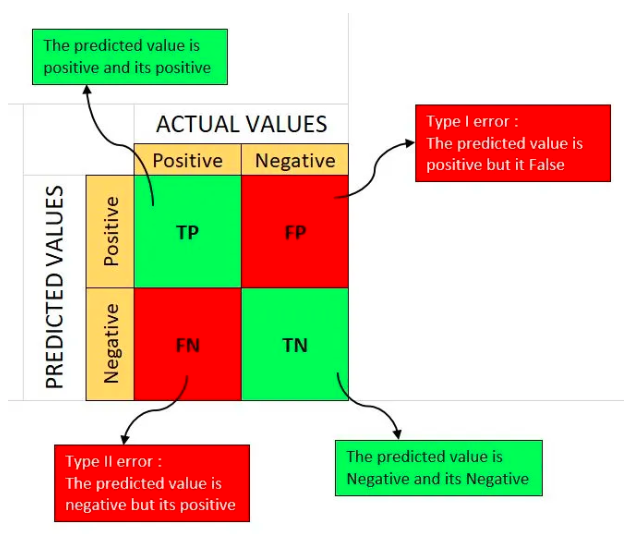


**Best Model Selection:**

Based on the evaluation metrics, the best model is Naive Bayes. Here’s why:

- Accuracy: Naive Bayes has the highest accuracy (0.8017), indicating it correctly classifies the highest percentage of tweets compared to the other models.
- Precision: While Logistic Regression has a slightly higher precision (0.8264), Naive Bayes follows closely (0.8172), indicating a strong ability to identify true positive disaster-related tweets.
- Recall: Naive Bayes has the highest recall (0.6888) among the three models, meaning it captures the most actual disaster-related tweets.
- F1 Score: Naive Bayes has the highest F1 score (0.7475), which balances both precision and recall, indicating overall better performance in identifying disaster-related tweets.
- Confusion Matrix: The confusion matrix of Naive Bayes shows a lower number of false negatives (202) compared to Logistic Regression (211) and a comparable number of false positives.

# Interpretation and Application

**1- Select the best model.**

In [16]:
# Choose the best model
best_model = MultinomialNB()
best_model.fit(X_train, y_train)


MultinomialNB()

In [17]:
# Predict on the test set
test_predictions = best_model.predict(X_test)

#### target: Target label (1 if the tweet is about a real disaster, 0 if not).

In [18]:
# Prepare the submission file
submission = pd.DataFrame({'id': df_test['id'], 'text':df_test['text'],'preds_target': test_predictions})
submission

,id,text,preds_target
0,0,Just happened a terrible car crash,1
1,2,"Heard about #earthquake is different cities, s...",0
2,3,"there is a forest fire at spot pond, geese are...",1
3,9,Apocalypse lighting. #Spokane #wildfires,1
4,11,Typhoon Soudelor kills 28 in China and Taiwan,1
...,...,...,...
3258,10861,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,1
3259,10865,Storm in RI worse than last hurricane. My city...,0
3260,10868,Green Line derailment in Chicago http://t.co/U...,1
3261,10874,MEG issues Hazardous Weather Outlook (HWO) htt...,1


### how the model's predictions can be used in disaster response and emergency management?

Using Model Predictions in Disaster Response and Emergency Management
The model's predictions can be a powerful tool in disaster response and emergency management in several ways. Below are some examples of how these predictions can be utilized in this context:

**1. Rapid Incident Detection:**

The model can be used to analyze the flow of tweets on social media in real-time to quickly identify emergency incidents and natural disasters. This can help in:

- Quickly pinpointing locations of incidents.
- Providing immediate reports to relevant authorities such as emergency teams and police.
- Enhancing response speed and reducing the time needed for necessary actions.

**2. Better Resource Allocation:**

By analyzing and classifying tweets as disaster-related or not, authorities can better allocate resources based on the most affected and impacted areas. This includes:

- Deploying rescue teams to the most affected areas.
- Providing medical and food supplies to areas in greater need.
- Improving the distribution of aid and resources based on actual needs gathered from social data.
  
**3. Managing Information and Rumors:**

The model can help filter out non-disaster-related tweets, reducing noise and misinformation. This enables authorities to focus on true and important information, helping to:

- Reduce the spread of rumors and incorrect information.
- Improve the accuracy of information provided to the public.
- Strengthen public trust in the agencies responsible for disaster management.

**4. Providing Detailed Reports and Analyses:**

Model predictions can be used to provide detailed reports and analyses on natural disasters:

- Analyzing temporal and spatial patterns of incidents.
- Assessing the impact of the disaster on communities and different regions.
- Providing accurate data to assist in future planning and risk mitigation.

**5. Enhancing Public Communication:**

Using classified tweets, authorities can improve communication strategies with the public by:

- Providing accurate and timely updates on the current situation.
- Offering direct advice and guidance to the affected public.
- Enhancing public awareness on how to act during emergencies.

#### Practical Example:


**1. Rapid Incident Detection:**

The model can analyze new tweets and classify them in real-time. If a large number of disaster-related tweets are detected in a particular area, an immediate alert can be sent to emergency teams.

**2. Resource Allocation:**

Based on classified tweets, additional emergency teams can be allocated to specific areas that receive a high volume of disaster-related tweets, such as fires or floods.

**3. Managing Information:**

The model can filter out non-disaster-related tweets, helping to reduce the spread of rumors and focus on genuine information.